In [2]:
!pip install ucimlrepo

In [3]:
import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
import math
import random
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

In [4]:
# fetch dataset
iris = fetch_ucirepo(id=53)

# data (as pandas dataframes)
X = iris.data.features
y = iris.data.targets

# concatenate X and y along the columns (axis=1)
df = pd.concat([X, y], axis=1)

# analyzing only two classes. Versicolor and Virginica
df = df[df['class'].isin(['Iris-versicolor', 'Iris-virginica'])]

# rename labels
df = df.replace({'Iris-versicolor': 0, 'Iris-virginica': 1}).reset_index(drop=True)

df

,sepal length,sepal width,petal length,petal width,class
0,7.0,3.2,4.7,1.4,0
1,6.4,3.2,4.5,1.5,0
2,6.9,3.1,4.9,1.5,0
3,5.5,2.3,4.0,1.3,0
4,6.5,2.8,4.6,1.5,0
...,...,...,...,...,...
95,6.7,3.0,5.2,2.3,1
96,6.3,2.5,5.0,1.9,1
97,6.5,3.0,5.2,2.0,1
98,6.2,3.4,5.4,2.3,1


In [5]:
# fetch dataset
breast_cancer_wisconsin_original = fetch_ucirepo(id=15)

# data (as pandas dataframes). Removing
X = breast_cancer_wisconsin_original.data.features.dropna()
y = breast_cancer_wisconsin_original.data.targets.iloc[X.index]

# concatenate X and y along the columns (axis=1)
dfc = pd.concat([X, y], axis=1)

# rename labels
dfc = dfc.rename(columns={'Class': 'class'}).replace({2: 0, 4: 1}).reset_index(drop=True)

dfc

,Clump_thickness,Uniformity_of_cell_size,Uniformity_of_cell_shape,Marginal_adhesion,Single_epithelial_cell_size,Bare_nuclei,Bland_chromatin,Normal_nucleoli,Mitoses,class
0,5,1,1,1,0,1.0,3,1,1,0
1,5,1,1,5,7,10.0,3,0,1,0
2,3,1,1,1,0,0.0,3,1,1,0
3,6,8,8,1,3,1.0,3,7,1,0
4,1,1,1,3,0,1.0,3,1,1,0
...,...,...,...,...,...,...,...,...,...,...
678,3,1,1,1,3,0.0,1,1,1,0
679,0,1,1,1,0,1.0,1,1,1,0
680,5,10,10,3,7,3.0,8,10,0,1
681,1,8,6,1,3,1.0,10,6,1,1


In [6]:
# spliting data into training and test sets 70:30. Expects a PandaFrame
class Data:
  def __init__(self, dataset):
    X = dataset.drop(columns=['class'])
    y = dataset['class']
    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, train_size=0.7)

In [ ]:
data = Data(df)

print(data.X_train, data.X_test)
print(data.y_train, data.y_test)

In [7]:
class SigmoidNeuron:
    def __init__(self, data: Data, inputs):
      self.analysis = Analysis()
      self.data = data
      self.weights = np.array([random.uniform(-0.01, 0.01) for _ in range(0, inputs)]) # inputs = nr of features + bias

    def sigmoid(self, a):
      return 1 / (1 + math.exp(-a))

    def predict(self, Xi):
      a = np.dot(Xi, self.weights)  # weighted sum a = Σx_k∙w_k
      return self.sigmoid(a)        # applying activation (sigmoid) function f(a)

    # batch gradient descent used
    def train(self, epochs, learning_rate): # variable hyperparameters
      print(learning_rate)
      epoch = 0  # initialize epoch counter
      while epoch < epochs:
          y_test_pred = []
          shuffled_X = self.data.X_train.sample(frac=1)  # randomly shuffle the training data
          shuffled_y = self.data.y_train.reindex(shuffled_X.index)  # adjust for shuffling
          gradient_sum = np.array([0.0 for _ in range(len(self.weights))])  # initialize gradient sum vector
          for (row_index, Xi), y_true in zip(shuffled_X.iterrows(), shuffled_y):
              Xi_nump = Xi.values
              Xi_with_bias = np.insert(Xi_nump, 0, 1.0) # the input vector with the bias term included. x0 = 1, because w0 = b.
              y_pred = self.predict(Xi_with_bias)
              y_test_pred.append(y_pred)
              for k in range(0, len(self.weights)):  # compute gradient sum for each weight
                gradient_sum[k] += (y_pred - y_true) * y_pred * (1 - y_pred) * Xi_with_bias[k]
          for k in range(0, len(self.weights)):  # update weights using gradient descent
              self.weights[k] -= learning_rate * gradient_sum[k] * (1.0 / len(shuffled_X))
          epoch += 1

          testing_results = [self.predict(np.insert(v.values, 0, 1.0)) for _, v in self.data.X_test.iterrows()] # Make predictions on test dataset with the current weights
          self.analysis.train.append((shuffled_y, y_test_pred)) # Save training history for this epoch
          self.analysis.test.append((self.data.y_test, testing_results)) # Save validation history for this epoch
          self.analysis.weights.append(self.weights)

In [8]:
class Analysis:
    def __init__(self):
      self.train = []
      self.test = []
      self.weights = []

    def calculate_MSE(self, t, y):
      return 1/len(y) * np.sum((y - t) ** 2)

    def plotMSE(self):
      training_errors = [self.calculate_MSE(t, y) for (t, y) in self.train]
      testing_errors  = [self.calculate_MSE(t, y) for (t, y) in self.test]
      plt.xlabel("Epocha")
      plt.ylabel("Vidutinė kvadratinė paklaida")
      plt.plot(training_errors, label='Mokymo aibė')
      plt.plot(testing_errors, label='Testavimo aibė')
      plt.legend()
      plt.show()

    def sigmoid_round(self, set):
          # classify the entire set
          classified = [(true_labels, [1 if pred >= 0.5 else 0 for pred in predictions]) for (true_labels, predictions) in set]
          return classified

    def plotAccuracy(self):
      train = self.sigmoid_round(self.train)
      test = self.sigmoid_round(self.test)
      plt.plot([metrics.accuracy_score(t, y) for (t, y) in train], label='Mokymo aibė')
      plt.plot([metrics.accuracy_score(t, y) for (t, y) in test], label='Testavimo aibė')
      plt.xlabel("Epocha")
      plt.ylabel("Klasifikavimo tikslumas")
      plt.legend()
      plt.show()

    def getMaxAccuracy(self):
      train = self.sigmoid_round(self.train)
      test = self.sigmoid_round(self.test)
      return (max([metrics.accuracy_score(t, y) for (t, y) in train]), max([metrics.accuracy_score(t, y) for (t, y) in test]))

    def getMinMSE(self):
      return (min([self.calculate_MSE(t, y) for (t, y) in self.train]), min([self.calculate_MSE(t, y) for (t, y) in self.test]))

    def getTrainAccuracyByIndex(self, index):
      train = self.sigmoid_round(self.train)
      return (metrics.accuracy_score(*train[index]))

    def getTrainMSEByIndex(self, index):
      return (self.calculate_MSE(*self.train[index]))

    def getTestAccuracyByIndex(self, index):
      test = self.sigmoid_round(self.test)
      return (metrics.accuracy_score(*test[index]))

    def getTestMSEByIndex(self, index):
      return (self.calculate_MSE(*self.test[index]))

    def getWeightsByIndex(self, index):
      return (self.weights[index])

    def findCommonEpoch(self):
        max_accuracy = 0
        min_mse = float('inf')
        common_epoch = 0

        train = self.sigmoid_round(self.train)
        for epoch, (train_labels, train_predictions) in enumerate(train):
            train_accuracy = metrics.accuracy_score(train_labels, train_predictions)
            train_mse = self.calculate_MSE(train_labels, train_predictions)

            if train_accuracy > max_accuracy and train_mse < min_mse:
                max_accuracy = train_accuracy
                min_mse = train_mse
                common_epoch = epoch

        return common_epoch

0.3


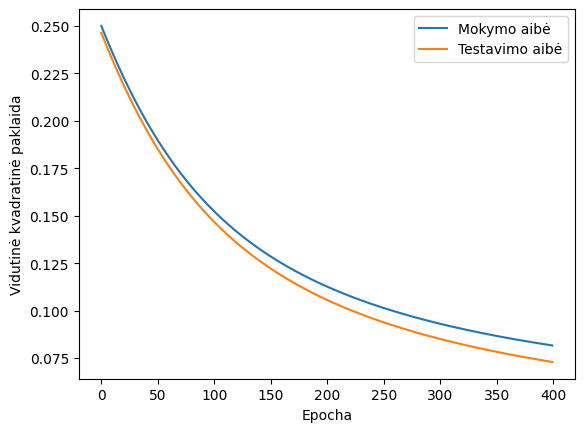

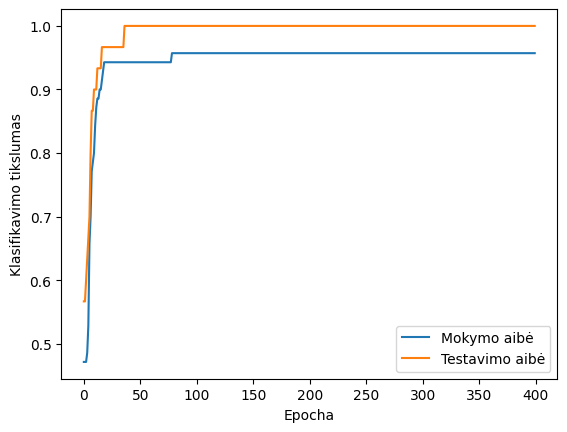

Epoch: 78, train loss/test loss: ((0.16655452225266612, 0.1613963364674646)), train accuracy/test accuracy: (0.9571428571428572, 1.0)
Epoch: 78, weights: [-0.70415932 -1.24811021 -0.85634722  1.64838084  1.73186704]
Min train/test MSE: (0.08160101389449023, 0.07292310347391481)
Max train/test accuracy: (0.9571428571428572, 1.0)


,Spėta,Tikra
0,Iris-virginica,Iris-virginica
1,Iris-virginica,Iris-virginica
2,Iris-virginica,Iris-virginica
3,Iris-versicolor,Iris-versicolor
4,Iris-versicolor,Iris-versicolor
5,Iris-versicolor,Iris-versicolor
6,Iris-virginica,Iris-virginica
7,Iris-versicolor,Iris-versicolor
8,Iris-virginica,Iris-virginica
9,Iris-virginica,Iris-virginica


In [ ]:
data = Data(df)
model_i = SigmoidNeuron(data, 5)
model_i.train(epochs=400, learning_rate=0.3)
model_i.analysis.plotMSE()
model_i.analysis.plotAccuracy()
ei = model_i.analysis.findCommonEpoch()
print(f"Epoch: {ei}, train loss/test loss: ({model_i.analysis.getTrainMSEByIndex(ei), model_i.analysis.getTestMSEByIndex(ei)}), train accuracy/test accuracy: {model_i.analysis.getTrainAccuracyByIndex(ei), model_i.analysis.getTestAccuracyByIndex(ei)}")
weights = model_i.analysis.getWeightsByIndex(ei)
print(f"Epoch: {ei}, weights: {weights}")
print(f"Min train/test MSE: {model_i.analysis.getMinMSE()}")
print(f"Max train/test accuracy: {model_i.analysis.getMaxAccuracy()}")
test_frames = pd.DataFrame({
    "Spėta": ['Iris-virginica' if model_i.predict(np.insert(p.values, 0, 1.0)) >= 0.5 else 'Iris-versicolor' for _, p in model_i.data.X_test.iterrows()],
    "Tikra": ['Iris-virginica' if p == 1 else 'Iris-versicolor' for p in model_i.data.y_test.values]
    })
test_frames

0.3


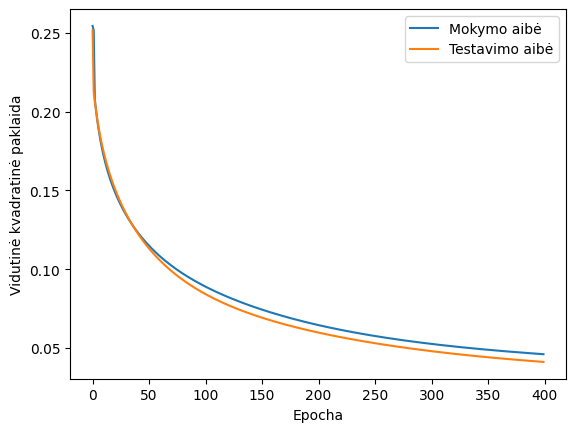

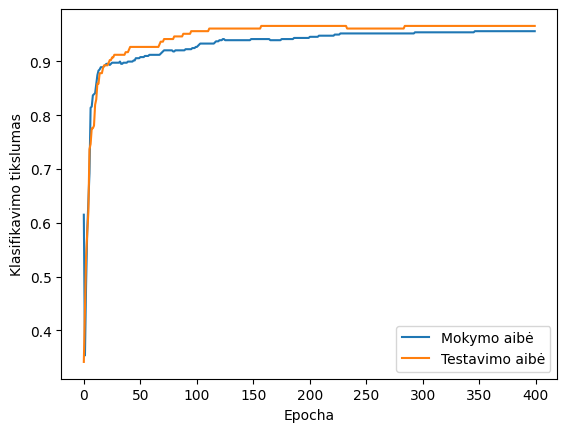

Epoch: 346, train loss/test loss: ((0.049177091666753485, 0.044449301760855896)), train accuracy/test accuracy: (0.9560669456066946, 0.9658536585365853)
Epoch: 346, weights: [-2.40838277  0.03709607  0.1656941   0.23499381  0.02679848  0.16379023
  0.20333431  0.02801564  0.0981906  -0.23449119]
Min train/test MSE: (0.04612315508372086, 0.04122443359163261)
Max train/test accuracy: (0.9560669456066946, 0.9658536585365853)


,Spėta,Tikra
0,Piktybinis,Piktybinis
1,Nepiktybinis,Nepiktybinis
2,Piktybinis,Piktybinis
3,Nepiktybinis,Nepiktybinis
4,Nepiktybinis,Nepiktybinis
...,...,...
200,Piktybinis,Piktybinis
201,Nepiktybinis,Nepiktybinis
202,Nepiktybinis,Nepiktybinis
203,Nepiktybinis,Nepiktybinis


In [11]:
data = Data(dfc)
model_c = SigmoidNeuron(data, 10)
model_c.train(epochs=400, learning_rate=0.3)
model_c.analysis.plotMSE()
model_c.analysis.plotAccuracy()
ec = model_c.analysis.findCommonEpoch()
print(f"Epoch: {ec}, train loss/test loss: ({model_c.analysis.getTrainMSEByIndex(ec), model_c.analysis.getTestMSEByIndex(ec)}), train accuracy/test accuracy: {model_c.analysis.getTrainAccuracyByIndex(ec), model_c.analysis.getTestAccuracyByIndex(ec)}")
weights = model_c.analysis.getWeightsByIndex(ec)
print(f"Epoch: {ec}, weights: {weights}")
print(f"Min train/test MSE: {model_c.analysis.getMinMSE()}")
print(f"Max train/test accuracy: {model_c.analysis.getMaxAccuracy()}")
c_test_frames = pd.DataFrame({
    "Spėta": ['Piktybinis' if model_c.predict(np.insert(p.values, 0, 1.0)) >= 0.5 else 'Nepiktybinis' for _, p in model_c.data.X_test.iterrows()],
    "Tikra": ['Piktybinis' if p == 1 else 'Nepiktybinis' for p in model_c.data.y_test.values]
  })
c_test_frames